# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


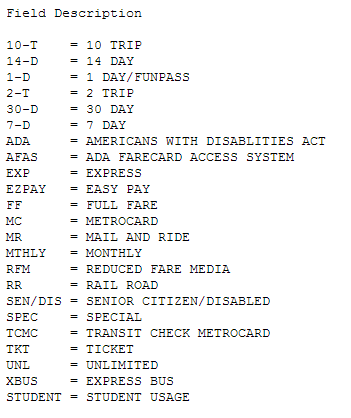

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [113]:
mtafare = np.load("MTA_Fare.npy")
mtafare.shape

(600, 23, 194)

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [88]:
print ("MTA array shape:", mtafare.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mtafare,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [89]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [114]:
mtafare = mtafare.astype(float)
for i in range(mtafare.shape[0]):
    for j in range(mtafare.shape[1]):
        mtafare[i,j][mtafare[i,j]== -1] = np.NaN

You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

Text(0.5,1,'time series (natural spave)')

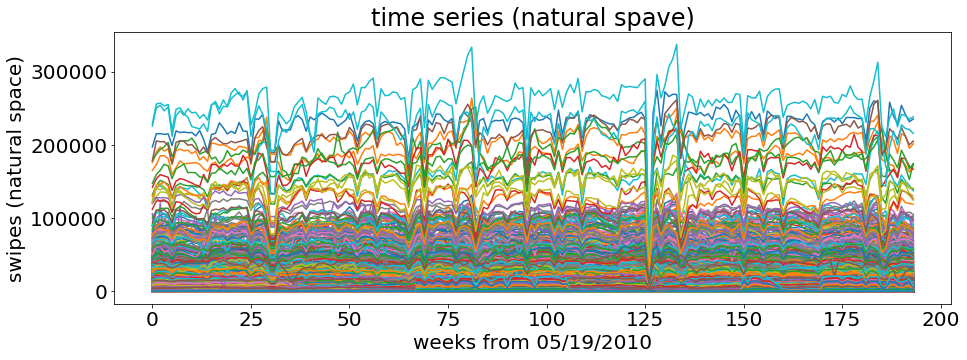

In [6]:
# plot the data in natural space
plt.figure(figsize=(15, 5))
for card_type in range(mtafare.shape[1]):
    for station_index in range(mtafare.shape[0]):
        plt.plot(mtafare[station_index, card_type, :])
plt.xlabel("weeks from 05/19/2010")
plt.ylabel("swipes (natural space)")
plt.title("time series (natural spave)")

#### Figure 1: time series for all ride types and all stations in natural space

Text(0.5,1,'time series (log space)')

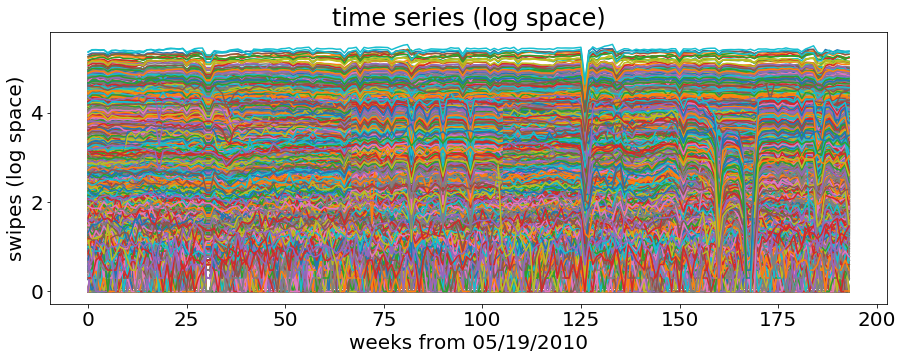

In [7]:
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
plt.figure(figsize=(15, 5))
for card_type in range(mtafare.shape[1]):
    for station_index in range(mtafare.shape[0]):
        plt.plot(np.log10(mtafare[station_index, card_type, :]))
plt.xlabel("weeks from 05/19/2010")
plt.ylabel("swipes (log space)")
plt.title("time series (log space)")

#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [8]:
sum_type = np.nansum(mtafare,axis = 1)
sum_type_station = np.nansum(sum_type,axis = 0)
small = sum_type_station.min()

Text(0.5,1,'Time series for the total swipes number ')

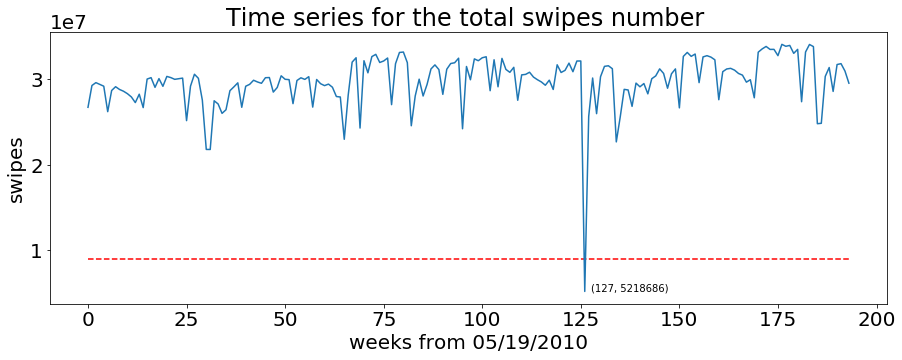

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(sum_type_station)
plt.hlines(3*np.nanstd(sum_type_station), xmin=0, xmax=193, label='3 sigmas', color="r", linestyle="--")
plt.annotate("(%d, %d)" % (sum_type_station.argmin() + 1, small), 
             xy=(sum_type_station.argmin() + 1 + 0.5, small), fontsize=10)
plt.xlabel("weeks from 05/19/2010")
plt.ylabel("swipes")
plt.title("Time series for the total swipes number ")

#### Figure 3: time series for the total swipes number.  The plot points out the week127 with lowest swipes number 5215466.

In [10]:
date = pd.date_range('05/19/2010', '02/19/2014', freq = 'W')
date[127]

Timestamp('2012-10-28 00:00:00', offset='W-SUN')

### New York was severely affected by Hurricane Sandy in 2012, particularly New York City. On October 28, New York Governor Andrew Cuomo declared a state of emergency for every county in the state. This may be the reason of a significant drop.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [11]:
sum_station = np.nansum(mtafare,axis = 0)

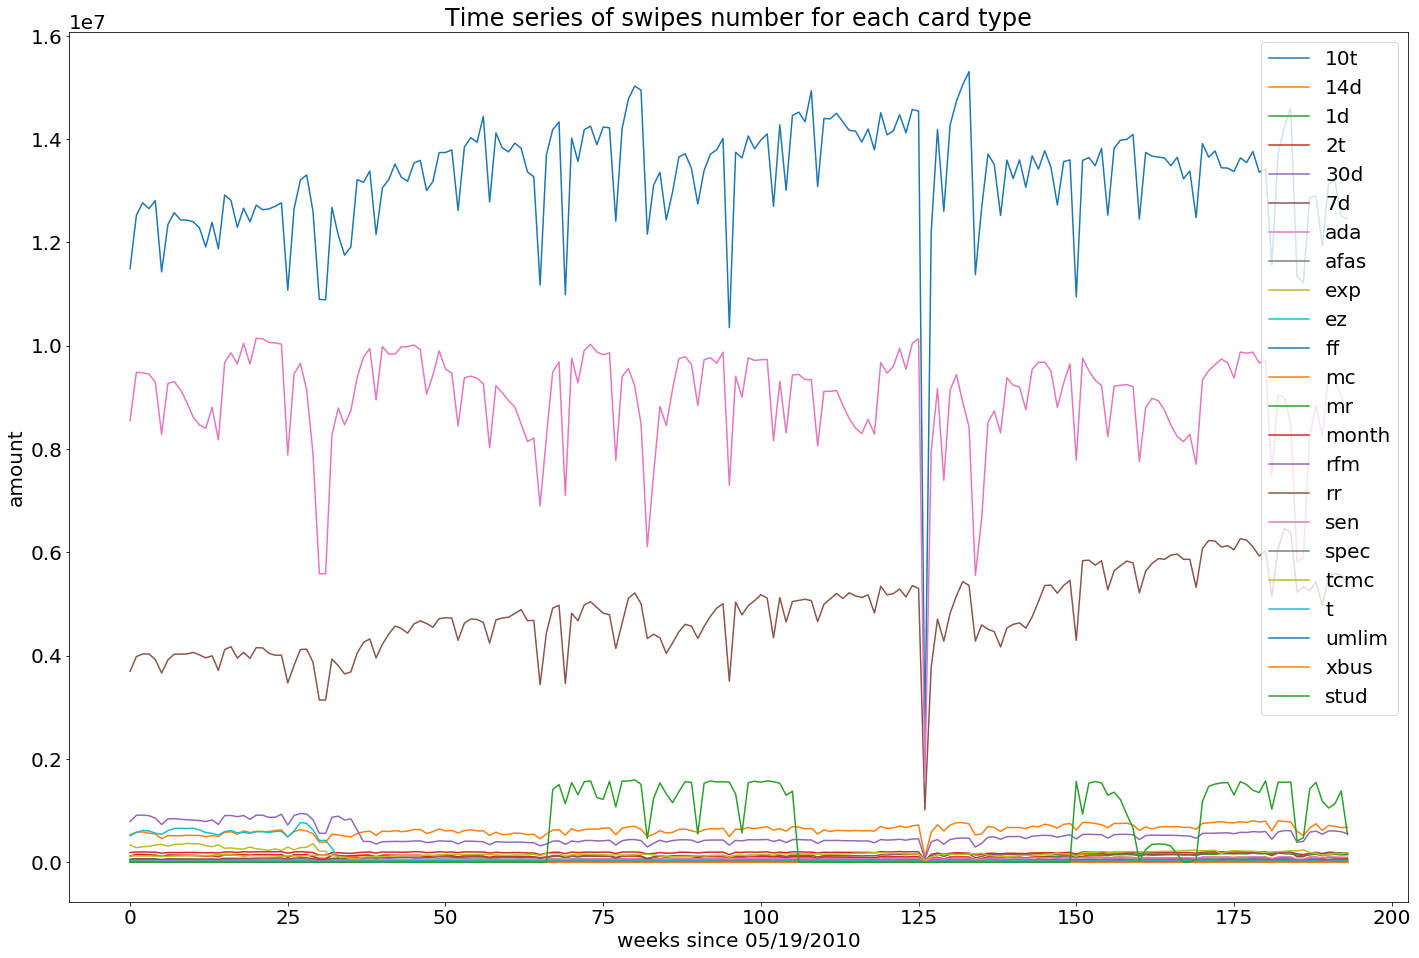

In [12]:
plt.figure(figsize(24,16))
for i in range(sum_station.shape[0]):
    plt.plot(sum_station[i], label=ridetype[i])
plt.title('Time series of swipes number for each card type')
plt.ylabel('amount')
plt.xlabel('weeks since 05/19/2010')
plt.legend()

#### Figure 4: Time series of swipes number for each card type.

In [13]:
df = pd.DataFrame(sum_station)
df_rolling_mean = pd.rolling_mean(df, window=10, min_periods=1)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,center=False,window=10).mean()
  from ipykernel import kernelapp as app


In [14]:
for i in range(ridetype.size):
    print('Card Type %i:' % (i+1))
    #print('Standard Devation: %d'% (sum_station[i].std()))
    print('Ratio: %2f' % (sum_station[i][0]/sum_station[i][193]))
    print('After Rolling Ratio: %4f' % (df_rolling_mean[0][i]/df_rolling_mean[193][i]))
    print()

Card Type 1:
Ratio: 0.922525
After Rolling Ratio: 0.922525

Card Type 2:
Ratio: 0.780760
After Rolling Ratio: 0.915194

Card Type 3:
Ratio: 0.866086
After Rolling Ratio: 0.914988

Card Type 4:
Ratio: 1.040075
After Rolling Ratio: 0.916666

Card Type 5:
Ratio: 0.998912
After Rolling Ratio: 0.916953

Card Type 6:
Ratio: 0.684069
After Rolling Ratio: 0.850090

Card Type 7:
Ratio: 0.982400
After Rolling Ratio: 0.891926

Card Type 8:
Ratio: inf
After Rolling Ratio: 0.892291

Card Type 9:
Ratio: 111065.666667
After Rolling Ratio: 0.904394

Card Type 10:
Ratio: 512032.000000
After Rolling Ratio: 0.922992

Card Type 11:
Ratio: 1.116995
After Rolling Ratio: 0.923790

Card Type 12:
Ratio: 0.786817
After Rolling Ratio: 0.929026

Card Type 13:
Ratio: 0.000027
After Rolling Ratio: 0.919993

Card Type 14:
Ratio: 1.657879
After Rolling Ratio: 0.922277

Card Type 15:
Ratio: 1.431343
After Rolling Ratio: 0.940689

Card Type 16:
Ratio: 0.350059
After Rolling Ratio: 1.071485

Card Type 17:
Ratio: 0.29127

### From looking at ratio after rolling, we can find card type 23 has steepest increase and card type 17 has steepest decrease.


# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [118]:
mta1 = mtafare.reshape(600*23,194)

In [119]:
mta = pd.DataFrame(mta1)

In [120]:
stationsmeans = sum_type.mean(axis=1)
stationsmeans.shape

(600,)

In [121]:
stationsstd = sum_type.std(axis=1)
stationsstd.shape

(600,)

In [122]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mtafare.reshape(600*23, 194).std(1) > 0]

array([  2,   2,   2, ..., 550, 550, 550])

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [123]:
mta.dropna(inplace=True)
mta.shape

(9174, 194)

In [124]:
# take the mean of the whole dataset / station mean
normed_time_series_mean = nanmean(mta1.flatten())/np.nanmean(mta1,axis=1)
normed_time_series_std = nanstd(mta1.flatten())/np.nanstd(mta1,axis=1)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [125]:
normed_time_series_std[:10]

array([   0.65147419,   22.64514743,  173.91545698,   61.80615557,
         82.16553962,    1.94983328,    1.1541407 ,  617.60409224,
          4.99853419,   11.66640447])

In [126]:
tsmean = np.nanmean(mta, axis=1)
tsstdev = np.nanstd(mta, axis=1)
tsmean.shape

(9174,)

In [127]:
tsmean[:10]

array([  3.54891753e+03,   1.44587629e+02,   1.79381443e+01,
         3.02577320e+01,   2.89690722e+00,   1.72666495e+03,
         1.25873711e+03,   3.86597938e-01,   4.62886598e+00,
         3.00618557e+01])

In [128]:
tsstdev[:10]

array([ 391.40042433,   43.60075488,    8.13711673,    9.80981872,
          4.23530701,  286.20893188,  182.35136007,    1.22685827,
         11.1163663 ,   67.14683317])

In [129]:
for i in range(len(mta)):
    mta.iloc[i] = (mta.iloc[i] - mta.iloc[i].mean()) / mta.iloc[i].std()

Text(0,0.5,'standardized number of rides')

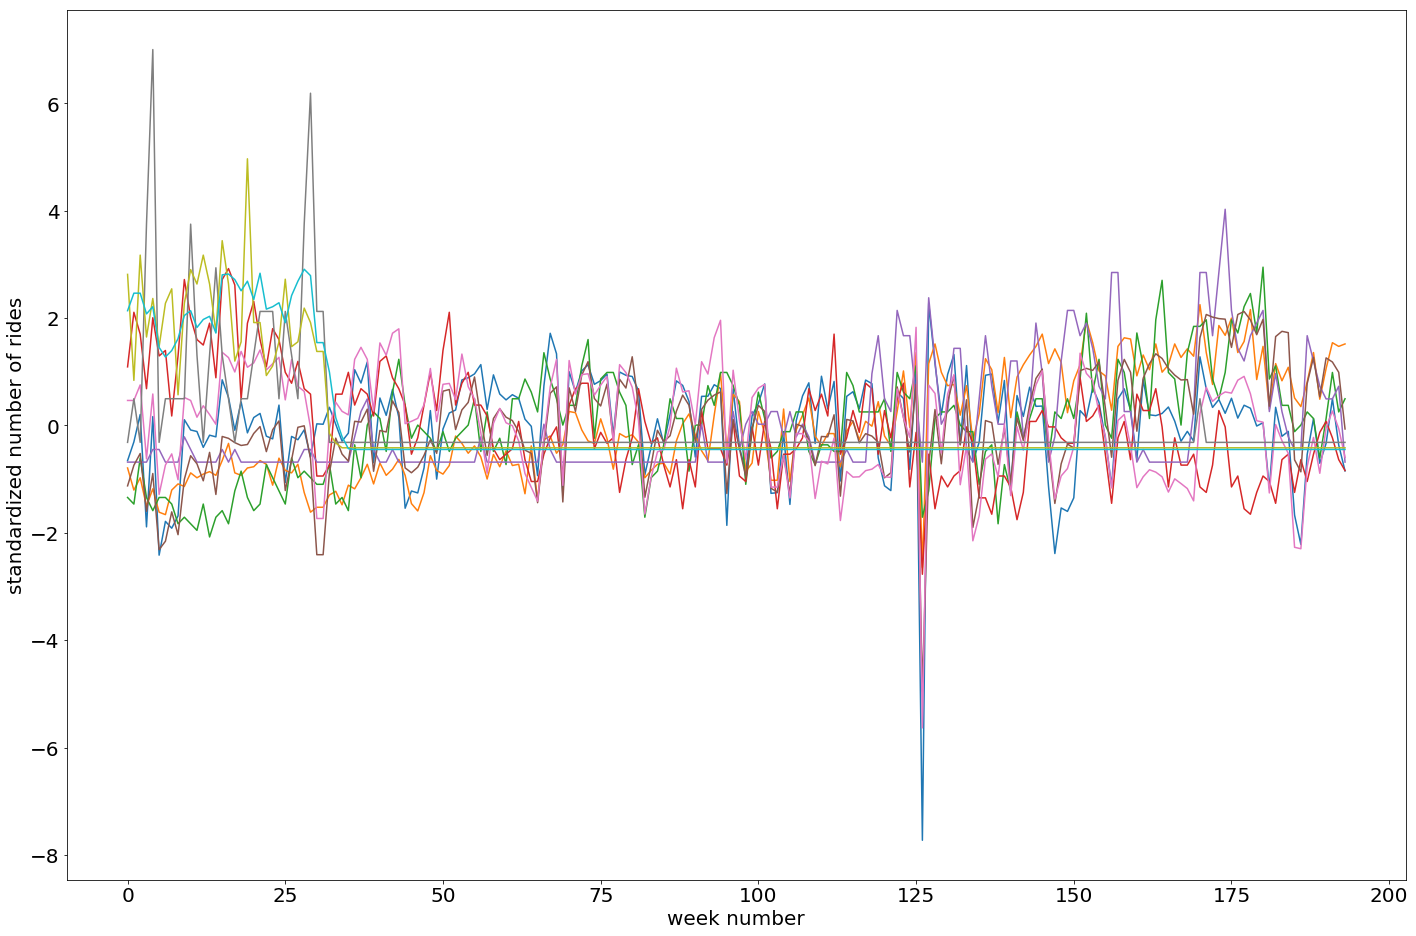

In [130]:
for i in range(10):
    pl.plot(mta.iloc[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [131]:
allfits = []
for i in range(len(mta)):
    smols = sm.OLS(mta.iloc[i], sm.add_constant(np.array(range(1, 195)))).fit()
    allfits.append(smols)
[a.params[0] for a in allfits[:10]]

[-0.0094895901564761749,
 -1.4660108028427916,
 -1.0773585201977185,
 1.0754554732526254,
 -1.0313188430176659,
 -0.87812667992441296,
 0.5763927451795634,
 0.75268898605428558,
 1.0527494268035062,
 1.1121374229167917]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normed_time_series_mean, normed_time_series_std]).T, 
    test_size=0.33, random_state=42)

ValueError: not enough values to unpack (expected 4, got 2)

In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

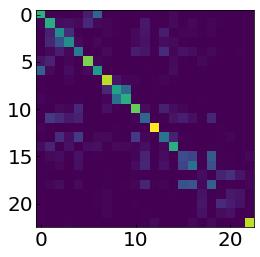

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

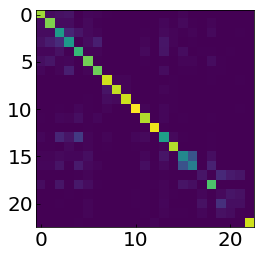

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   